# PB testing

In [1]:
import pandas as pd
import numpy as np

#Packages for GUIs (widgets) in python
from tkinter import Tk, filedialog
from ipywidgets import *
from IPython.display import clear_output, display

import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
from ast import literal_eval
import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
os.chdir('/home/dlawrence/GitHub/rcs-simulation')
from rcssim import rcs_sim as rcs

# Load data

In [5]:
print('Select folder containing data and settings files.')
data_folder = filedialog.askdirectory()

Select folder containing data and settings files.


##### Open file dialog for selecting neural data (.csv)
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

print('Select folder containing data and settings files.')
data_folder = filedialog.askdirectory()

root.destroy()

# PB1

### Load measured datasets and settings

In [6]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_pb1.csv')
settings = pd.read_csv(data_folder + '/dataset_pb1_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [7]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,pb1
0,0.000,NaN,NaN
1,0.002,NaN,NaN


In [8]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,500,256,100,7,"[[26.37, 34.18]]"


In [9]:
settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)

In [10]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,500,256,100,7,"[[26.37, 34.18]]"


### TD --> PB

In [11]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.11753320693969727


In [12]:
data_meas.head(2)

,timestamp,td1,pb1
0,0.000,NaN,NaN
1,0.002,NaN,NaN


In [13]:
data_sim.head(2)

,timestamp,td1,pb1
0,0.000,NaN,NaN
1,0.002,NaN,NaN


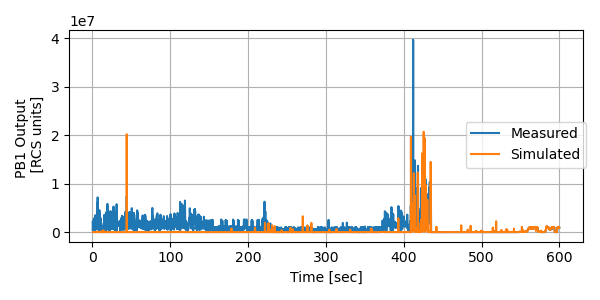

In [14]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(6,3), sharex='col', sharey=False)

ax.plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax.plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax.legend(bbox_to_anchor=(1.02, 0.6))\

ax.grid()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('PB1 Output \n [RCS units]')

plt.tight_layout()

# PB2

### Load measured datasets and settings

In [15]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_pb2.csv')
settings = pd.read_csv(data_folder + '/dataset_pb2_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [16]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,pb3,pb4,pb5,pb6,pb7,...,pb10,pb20,pb30,pb40,pb50,pb60,pb70,pb80,pb90,pb100
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,500,1024,100,7,"[[1, [0.73,1.22], [1, [1.71,2.20], [1, [2.69,3..."


In [18]:
pbs = [[[0.73,1.22],
       [1.71,2.20],
       [2.69,3.17],
       [3.66,4.15],
       [4.64,5.13],
       [5.62,6.10],
       [6.59,7.08],
       [7.57,8.06],
       [8.54,9.03],
       [9.52,10.01],
       [19.78,20.26],
       [29.54,30.03],
       [39.79,40.28],
       [49.56,50.05],
       [59.81,60.30],
       [69.58,70.07],
       [79.83,80.32],
       [89.60,90.09],
       [99.85,100.34]]]

In [19]:
settings['band_edges_hz'] = pbs

In [20]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,500,1024,100,7,"[[0.73, 1.22], [1.71, 2.2], [2.69, 3.17], [3.6..."


### TD --> PB

In [21]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)

for i in np.arange(data_pb.shape[1]):
    cols = data_meas.columns[-19:]
    data_sim.loc[pb_sample_mask,cols[i]] = data_pb[:,i]

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.449291467666626


In [22]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,pb3,pb4,pb5,pb6,pb7,...,pb10,pb20,pb30,pb40,pb50,pb60,pb70,pb80,pb90,pb100
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data_sim.head(2)

,timestamp,td1,pb1,pb2,pb3,pb4,pb5,pb6,pb7,pb8,...,pb10,pb20,pb30,pb40,pb50,pb60,pb70,pb80,pb90,pb100
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


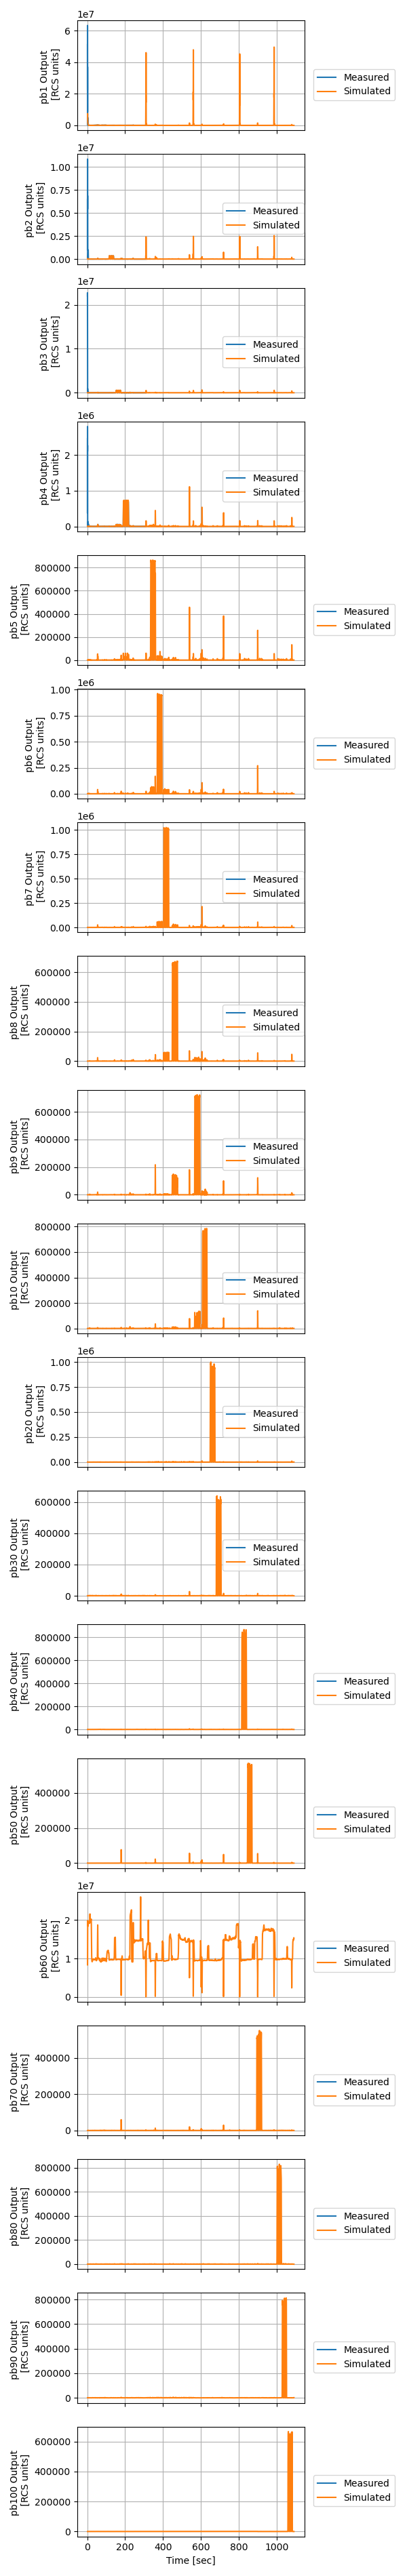

In [24]:
%matplotlib widget

fig, ax = plt.subplots(19,1, figsize=(6,38), sharex='col', sharey=False)
cols = data_meas.columns[-19:]

for i in np.arange(19):
    ax[i].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
               data_meas.loc[~np.isnan(data_meas.pb1), cols[i]], label='Measured')
    ax[i].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
               data_sim.loc[~np.isnan(data_sim.pb1), cols[i]], label='Simulated')
    ax[i].legend(bbox_to_anchor=(1.02, 0.6))\

    ax[i].grid()
    ax[i].set_ylabel(f'{cols[i]} Output \n [RCS units]')
    
ax[18].set_xlabel('Time [sec]')

plt.tight_layout()

# PB3a

### Load measured datasets and settings

In [25]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_pb3a.csv')
settings = pd.read_csv(data_folder + '/dataset_pb3a_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [26]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,pb1
0,0.000,-0.463282,NaN
1,0.004,-0.210799,NaN


In [27]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,250,64,100,7,"[29.30,33.20]"


In [28]:
settings['band_edges_hz'] = [[[29.30,33.20]]]

In [29]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,250,64,100,7,"[[29.3, 33.2]]"


### TD --> PB

In [30]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.013761758804321289


In [31]:
data_meas.head(2)

,timestamp,td1,pb1
0,0.000,-0.463282,NaN
1,0.004,-0.210799,NaN


In [32]:
data_sim.head(2)

,timestamp,td1,pb1
0,0.000,-0.463282,NaN
1,0.004,-0.210799,NaN


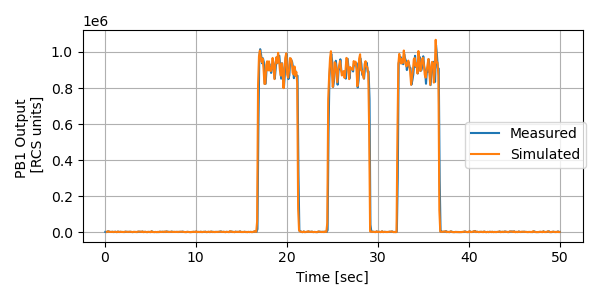

In [33]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(6,3), sharex='col', sharey=False)

ax.plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax.plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax.legend(bbox_to_anchor=(1.02, 0.6))\

ax.grid()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('PB1 Output \n [RCS units]')

plt.tight_layout()

# PB3b

### Load measured datasets and settings

In [34]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_pb3b.csv')
settings = pd.read_csv(data_folder + '/dataset_pb3b_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [35]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,pb1
0,0.000,0.931316,NaN
1,0.004,0.822785,NaN


In [36]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,250,256,100,7,"[29.79,30.76]"


In [37]:
settings['band_edges_hz'] = [[[29.30,33.20]]]

In [38]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,250,256,100,7,"[[29.3, 33.2]]"


### TD --> PB

In [39]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.00815892219543457


In [40]:
data_meas.head(2)

,timestamp,td1,pb1
0,0.000,0.931316,NaN
1,0.004,0.822785,NaN


In [41]:
data_sim.head(2)

,timestamp,td1,pb1
0,0.000,0.931316,NaN
1,0.004,0.822785,NaN


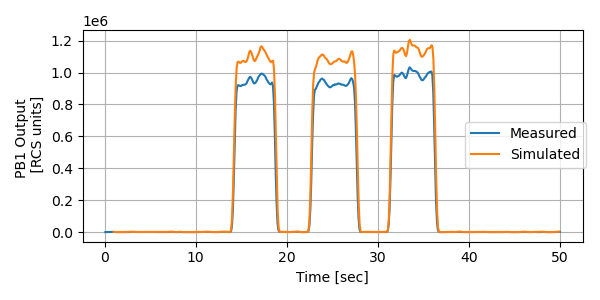

In [42]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(6,3), sharex='col', sharey=False)

ax.plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax.plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax.legend(bbox_to_anchor=(1.02, 0.6))\

ax.grid()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('PB1 Output \n [RCS units]')

plt.tight_layout()

# PB3c

### Load measured datasets and settings

In [43]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_pb3c.csv')
settings = pd.read_csv(data_folder + '/dataset_pb3c_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [44]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,pb1
0,0.000,-0.615226,NaN
1,0.004,-0.422138,NaN


In [45]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,250,1024,100,7,"[29.91,30.15]"


In [46]:
settings['band_edges_hz'] = [[[29.30,33.20]]]

In [47]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,250,1024,100,7,"[[29.3, 33.2]]"


### TD --> PB

In [48]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.014868736267089844


In [49]:
data_meas.head(2)

,timestamp,td1,pb1
0,0.000,-0.615226,NaN
1,0.004,-0.422138,NaN


In [50]:
data_sim.head(2)

,timestamp,td1,pb1
0,0.000,-0.615226,NaN
1,0.004,-0.422138,NaN


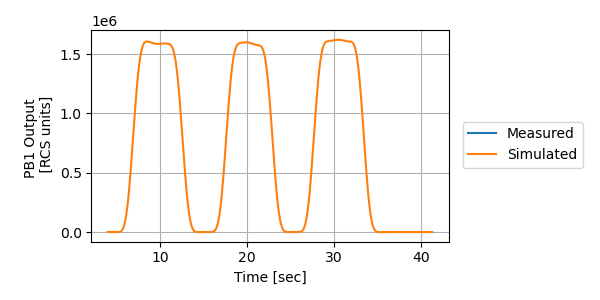

In [51]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(6,3), sharex='col', sharey=False)

ax.plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax.plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax.legend(bbox_to_anchor=(1.02, 0.6))\

ax.grid()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('PB1 Output \n [RCS units]')

plt.tight_layout()

# PB4

### Load measured datasets and settings

In [52]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_pb4.csv')
settings = pd.read_csv(data_folder + '/dataset_pb4_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [53]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,pb1,pb2,pb3,pb4,pb5,pb6,pb7,pb8
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,500,256,100,"[0,1,2,3,4,5,6,7]","[28.32,30.27]"


In [55]:
settings['band_edges_hz'] = [[[29.30,33.20]]]
settings['bit_shift'] = [np.array([0,1,2,3,4,5,6,7])]

In [56]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz
0,500,256,100,"[0, 1, 2, 3, 4, 5, 6, 7]","[[29.3, 33.2]]"


### TD --> PB

In [57]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0][0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.05726027488708496


In [58]:
data_meas.head(2)

,timestamp,td1,pb1,pb2,pb3,pb4,pb5,pb6,pb7,pb8
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
data_sim.head(2)

,timestamp,td1,pb1
0,0.000,NaN,NaN
1,0.002,NaN,NaN


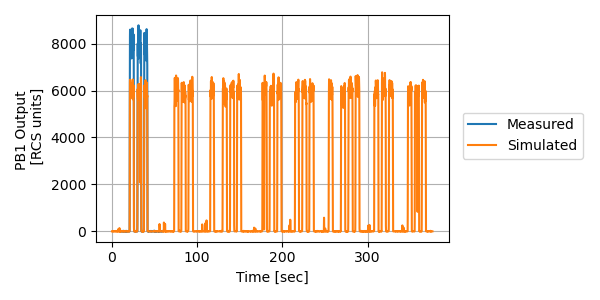

In [60]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(6,3), sharex='col', sharey=False)

ax.plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax.plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax.legend(bbox_to_anchor=(1.02, 0.6))\

ax.grid()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('PB1 Output \n [RCS units]')

plt.tight_layout()